In [1]:
""" Filter based on h3 hexagons mapped to polygons

aws emr add-steps --cluster-id <Your EMR cluster id> --steps Type=spark,Name=TestJob,Args=[--deploy-mode,cluster,--master,yarn,--conf,spark.yarn.submit.waitAppCompletion=true,s3a://your-source-bucket/code/pythonjob.py,s3a://your-source-bucket/data/data.csv,s3a://your-destination-bucket/test-output/],ActionOnFailure=CONTINUE
"""

from collections import namedtuple
import logging
import sys

from sedona.register import SedonaRegistrator  
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from pyspark.sql.functions import udf
from sedona.utils.adapter import Adapter
#from sedona.core.formatMapper.geojsonReader import GeoJsonReader
from sedona.core.formatMapper.shapefileParser import ShapefileReader
from sedona.core.SpatialRDD import PointRDD, SpatialRDD, CircleRDD
from sedona.sql.types import GeometryType
from sedona.core.enums import GridType
from sedona.core.spatialOperator import JoinQueryRaw
from sedona.core.spatialOperator import JoinQuery
from sedona.core.enums import IndexType
from sedona.core.formatMapper.disc_utils import load_spatial_rdd_from_disc, GeoType
from sedona.core.formatMapper import WktReader


import pyproj

from geopy.distance import great_circle
import pandas as pd
import geopandas as gpd
import os

from datetime import timedelta, date, datetime
from statistics import *

from pyspark import SparkContext

from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.window import Window
from pyspark.sql.types import (
    StructType,
    LongType,
    StructField,
    IntegerType,
    StringType,
    DoubleType,
    TimestampType,
    ArrayType
)
from pyspark.sql.functions import (
    from_utc_timestamp,
    to_utc_timestamp,
    dayofyear,
    col,
    unix_timestamp,
    monotonically_increasing_id,
    pandas_udf,
    PandasUDFType,
    col,
    asc,
    lit,
    countDistinct,
)
import pyspark.sql.functions as F
from math import *
import time

from shapely.wkt import loads as wkt_loads
from shapely.geometry import Point, Polygon, shape
from shapely.ops import transform
import shapely

from matplotlib import pyplot as plt

spark = (SparkSession.builder.appName("sedona")
                 .config("spark.serializer", KryoSerializer.getName)          
        .config("spark.kryo.registrator",     
                  SedonaKryoRegistrator.getName)    
         .config("spark.driver.maxResultSize", "3g")
    .getOrCreate() 
        )


# Register Sedona UDTs and UDFs
SedonaRegistrator.registerAll(spark)

spark.sparkContext.addPyFile("s3://ipsos-dvd/scripts/utils.py")
from utils import *
import h3_pyspark as h3s
#import h3pandas 
import h3 as h3
import io



@udf("boolean")
def pip_filter(poly_wkt, point_x, point_y):
    from shapely import wkt
    from shapely import geometry
    polygon = wkt.loads(poly_wkt)
    point = geometry.Point(point_x, point_y)
    return polygon.contains(point)

schema = StructType([
    StructField("dirty", ArrayType(StringType()), False),
    StructField("hexes", ArrayType(StringType()), False)
])


def parse_dates(x):
    if "/" in x:
        start_date = datetime.strptime(x.split('/')[0], "%Y-%m-%d")
        end_date = datetime.strptime(x.split('/')[1], "%Y-%m-%d")
        delta = end_date - start_date
        date_list = []
        for i in range(delta.days + 1):
            date = start_date + timedelta(days = i)
            date_list.append(date.strftime("%Y/%m/%d"))
        return(date_list)
    else: 
        return([x.replace("-", "/")])
    
def create_point(longitude: float, latitude: float):
    return Point(longitude, latitude)

create_point_udf = udf(create_point, GeometryType())


def create_polygon(wkt: str):
    return wkt_loads(wkt)

create_polygon_udf = udf(create_polygon, GeometryType())

def transform_geometry(geom, crs_from = 'EPSG:4326', crs_to = 'EPSG:9311'):
    wgs84 = pyproj.CRS(crs_from)
    utm = pyproj.CRS(crs_to)

    project = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform

    # Ensure that the input geometry is a shapely geometry object
    if not isinstance(geom, (shapely.geometry.base.BaseGeometry, shapely.geometry.base.BaseMultipartGeometry)):
        geom = shape(geom)

    utm_point = transform(project, geom)
    
    return utm_point

transform_geometry_udf = udf(transform_geometry, GeometryType())


def shared_polygon(long, lat):
    return Point(long, lat).buffer(35)
shared_polygon_udf = udf(shared_polygon, GeometryType())

def buffer(geom, meters):
    return geom.buffer(meters)
buffer_udf = udf(buffer, GeometryType())

def parse_dates(x):
    if "/" in x:
        start_date = datetime.strptime(x.split('/')[0], "%Y-%m-%d")
        end_date = datetime.strptime(x.split('/')[1], "%Y-%m-%d")
        delta = end_date - start_date
        date_list = []
        for i in range(delta.days + 1):
            date = start_date + timedelta(days = i)
            date_list.append(date.strftime("%Y/%m/%d"))
        return(date_list)
    else: 
        return([x.replace("-", "/")])
    
def saveFigS3(fn, fig):
    
    # Create an s3 client
    s3 = boto3.resource('s3')

    # Set the bucket name and object name
    bucket = s3.Bucket('ipsos-dvd')

    img_data = io.BytesIO()
    fig.savefig(img_data, format='png', bbox_inches='tight')
    img_data.seek(0)
    

    # Upload the plot to s3
    bucket.put_object(Body=img_data, ContentType='image/png', Key=fn)
    
essential_fields = [
        StructField("utc_timestamp",LongType(),False),
        StructField("caid",StringType(),False),
        StructField("latitude",DoubleType(),False),
        StructField("longitude",DoubleType(),False),
        StructField("altitude",DoubleType(),False),
]
raw_schema = StructType(
    essential_fields + [
        StructField("id_type",StringType(),False),
        StructField("geo_hash",StringType(),False),
        StructField("horizontal_accuracy",DoubleType(),False),
        StructField("ip_address",StringType(),False),
        #StructField("altitude",DoubleType(),False),
        StructField("iso_country_code",StringType(),False)]
)

#------
# parameters
#------

data_dir = "s3://external-safegraph/"
data_dyn = "s3://ipsos-dvd/dyn/data/"
figs_dir = "s3://ipsos-dvd/dyn/results/figs/"
data_veraset = "s3://external-veraset-data-us-west-2/us/"




VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
4,application_1709223206931_0005,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# configurations = spark.sparkContext.getConf().getAll()
# for item in configurations: print(item)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Join Places and Spend and Filter on Grocery Stores

In [ ]:
schema = StructType([
    StructField("placekey", StringType(), True),
    StructField("parent_placekey", StringType(), True),
    StructField("safegraph_brand_ids", StringType(), True),
    StructField("location_name", StringType(), True),
    StructField("brands", StringType(), True),
    StructField("store_id", StringType(), True),
    StructField("top_category", StringType(), True),
    StructField("sub_category", StringType(), True),
    StructField("naics_code", StringType(), True),
    StructField("latitude", StringType(), True),
    StructField("longitude", StringType(), True),
    StructField("street_address", StringType(), True),
    StructField("city", StringType(), True),
    StructField("region", StringType(), True),
    StructField("postal_code", StringType(), True),
    StructField("open_hours", StringType(), True),
    StructField("category_tags", StringType(), True),
    StructField("opened_on", StringType(), True),
    StructField("closed_on", StringType(), True),
    StructField("tracking_closed_since", StringType(), True),
    StructField("websites", StringType(), True),
    StructField("geometry_type", StringType(), True),
    StructField("polygon_wkt", StringType(), True),
    StructField("polygon_class", StringType(), True),
    StructField("enclosed", StringType(), True),
    StructField("phone_number", StringType(), True),
    StructField("is_synthetic", StringType(), True),
    StructField("includes_parking_lot", StringType(), True),
    StructField("iso_country_code", StringType(), True),
    StructField("wkt_area_sq_meters", StringType(), True)
])

places = (sqlContext.read.format('com.databricks.spark.csv')
         .options(header='true', inferschema='true')
         .option('escape','"') # this is necessary because the fields contain "," as well but dont have quotes around them
         .load(data_dir + "places/*.gz"))
places = places.cache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
schema = StructType([
    StructField("placekey", StringType(), True),
    StructField("safegraph_brand_ids", StringType(), True),
    StructField("brands", StringType(), True),
    StructField("spend_date_range_start", StringType(), True),
    StructField("spend_date_range_end", StringType(), True),
    StructField("raw_total_spend", StringType(), True),
    StructField("raw_num_transactions", StringType(), True),
    StructField("raw_num_customers", StringType(), True),
    StructField("median_spend_per_transaction", StringType(), True),
    StructField("median_spend_per_customer", StringType(), True),
    StructField("spend_per_transaction_percentiles", StringType(), True),
    StructField("spend_by_day", StringType(), True),
    StructField("spend_per_transaction_by_day", StringType(), True),
    StructField("spend_by_day_of_week", StringType(), True),
    StructField("day_counts", StringType(), True),
    StructField("spend_pct_change_vs_prev_month", StringType(), True),
    StructField("spend_pct_change_vs_prev_year", StringType(), True),
    StructField("online_transactions", StringType(), True),
    StructField("online_spend", StringType(), True),
    StructField("transaction_intermediary", StringType(), True),
    StructField("spend_by_transaction_intermediary", StringType(), True),
    StructField("bucketed_customer_frequency", StringType(), True),
    StructField("mean_spend_per_customer_by_frequency", StringType(), True),
    StructField("bucketed_customer_incomes", StringType(), True),
    StructField("mean_spend_per_customer_by_income", StringType(), True),
    StructField("customer_home_city", StringType(), True),
    StructField("related_cross_shopping_physical_brands_pct", StringType(), True),
    StructField("related_cross_shopping_online_merchants_pct", StringType(), True),
    StructField("related_cross_shopping_same_category_brands_pct", StringType(), True),
    StructField("related_cross_shopping_local_brands_pct", StringType(), True),
    StructField("related_wireless_carrier_pct", StringType(), True),
    StructField("related_streaming_cable_pct", StringType(), True),
    StructField("related_delivery_service_pct", StringType(), True),
    StructField("related_rideshare_service_pct", StringType(), True),
    StructField("related_buynowpaylater_service_pct", StringType(), True),
    StructField("related_payment_platform_pct", StringType(), True)
])
spend = (sqlContext.read.format('com.databricks.spark.csv')
         .options(header='true', inferschema='true')
         .option('escape','"') # this is necessary because the fields contain "," as well but dont have quotes around them
         .load(data_dir + "spend/*.gz"))
spend = spend.cache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
colskeep = [x for x in places.columns if x not in spend.columns or x == "placekey"]
places = places.select(colskeep)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
spend = spend.join(places, on = "placekey", how = "left")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# filter on grocery stores
category_list =  ["Grocery Stores", 'Grocery and Related Product Merchant Wholesalers', 
              "General Merchandise Stores, including Warehouse Clubs and Supercenters", 
              ]

spend = spend.filter(F.col("top_category").isin(category_list))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
spend.write.mode("overwrite").parquet(os.path.join(data_dyn, "spend_places"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
START_DATE = "2022-06-01"
END_DATE = "2022-06-30"
dates = [START_DATE + "/" + END_DATE]

# set up date ranges in path form
datelist = []
for arg in dates:
    temp = parse_dates(arg)
    datelist.extend(temp)
datelist

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['2022/06/01', '2022/06/02', '2022/06/03', '2022/06/04', '2022/06/05', '2022/06/06', '2022/06/07', '2022/06/08', '2022/06/09', '2022/06/10', '2022/06/11', '2022/06/12', '2022/06/13', '2022/06/14', '2022/06/15', '2022/06/16', '2022/06/17', '2022/06/18', '2022/06/19', '2022/06/20', '2022/06/21', '2022/06/22', '2022/06/23', '2022/06/24', '2022/06/25', '2022/06/26', '2022/06/27', '2022/06/28', '2022/06/29', '2022/06/30']

## Find Veraset devices visiting shops

In [ ]:
reload_polys = True

if reload_polys:
    # store polygons to sedona
    spend = spark.read.parquet(os.path.join(data_dyn, "spend_places")).select("placekey", "polygon_wkt", 'wkt_area_sq_meters',
                                                                         "polygon_class", "latitude", "longitude")
    # transform to local crs in meters
    polys = (spend.dropDuplicates(["polygon_wkt"])
                .withColumn("polygon", transform_geometry_udf(create_polygon_udf(F.col("polygon_wkt"))))
            )

    # use buffered centroid for shared polygons like malls
    polys = (polys.withColumn("polygon", when(F.col("polygon_class") == "SHARED_POLYGON", 
                                             shared_polygon_udf(F.col("longitude"), F.col("latitude")))
                                        .otherwise(F.col("polygon"))
                            )
                 .withColumn("polygon", transform_geometry_udf(buffer_udf(F.col("polygon"), lit(25)), lit("epsg:9311"), lit("epsg:4326"))
                            )
                 .select("placekey", "polygon")
        )

    # polygons to spatial rdd
    polygons_rdd = Adapter.toSpatialRdd(polys.drop("polys_wkt"), "polygon")#.transform('epsg:4326', 'epsg:9311')

    polygons_rdd.saveAsWKT(data_dyn + "polygons_rdd/polygons_rdd")

polygons_rdd = WktReader.readToGeometryRDD(sc, data_dyn + "polygons_rdd/polygons_rdd", 0, True, False)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# count the data for the paper

redo_count = True

#path = "s3://ipsos-dvd/dyn/data/pings/2022/09/01/part-00000-22976405-43c9-4222-a04b-d07840d3c9e9-c000.snappy.parquet"
if redo_count:

    essential_fields = [
            StructField("utc_timestamp",LongType(),False),
            StructField("caid",StringType(),False),
            StructField("latitude",DoubleType(),False),
            StructField("longitude",DoubleType(),False),
            StructField("altitude",DoubleType(),False),
    ]
    raw_schema = StructType(
        essential_fields + [
            StructField("id_type",StringType(),False),
            StructField("geo_hash",StringType(),False),
            StructField("horizontal_accuracy",DoubleType(),False),
            StructField("ip_address",StringType(),False),
            #StructField("altitude",DoubleType(),False),
            StructField("iso_country_code",StringType(),False)]
    )
    pings = (spark.read.schema(raw_schema).option("recursiveFileLookup","true")
             .parquet(data_veraset + "2022").select("latitude", "longitude", "caid", "utc_timestamp")# .limit(1000)
            )
    print(pings.count())
    print(pings.dropDuplicates(["caid"]).count())

    


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Testing Sedona

In [ ]:
# use spatial partitioning
grid_type = GridType.KDBTREE



START_DATE = "2022-06-25"
END_DATE = "2022-06-30"
dates = [START_DATE + "/" + END_DATE]

# set up date ranges in path form
datelist = []

for arg in dates:
    temp = parse_dates(arg)
    datelist.extend(temp)
# create list of s3 folders for dates to get
base_bucket = f"s3://external-veraset-data-us-west-2/us/" # f"s3://external-veraset-data-us-west-2/us/" # f"s3://external-veraset-data-us-west-2/movement/"
#base_bucket = f"/home/antonvocalis/ipsos/data/in/veraset/"

for date in datelist:
    print(date)
    path = data_veraset + date
    redo_points = True

    if redo_points:
        pings = spark.read.schema(raw_schema).parquet(path).select("latitude", "longitude", "caid", "utc_timestamp")# .limit(1000)
        pings.createOrReplaceTempView("pings")

        # Read Hive table
        pings = spark.sql(
              """SELECT ST_Point(cast(pings.longitude as Decimal(24,20)), cast(pings.latitude as Decimal(24,20))) AS point, 
              utc_timestamp, caid
              FROM pings;
              """
        )
        pings.write.mode("overwrite").parquet(data_dyn + "pings/" + date)

    
    pings = spark.read.parquet(data_dyn + "pings/" + date).select("point", "caid", "utc_timestamp") #.limit(1000000)
    pings = pings.repartition(10000, "caid")

    
    # convert to spatial rdds
    points_rdd = Adapter.toSpatialRdd(pings, "point")#.transform('epsg:4326', 'epsg:9311')
    

    points_rdd.analyze()
    points_rdd.spatialPartitioning(grid_type)

    polygons_rdd = WktReader.readToGeometryRDD(sc, data_dyn + "polygons_rdd/polygons_rdd", 0, True, False)
    polygons_rdd.analyze()
    polygons_rdd.spatialPartitioning(points_rdd.getPartitioner())

    build_on_spatial_partitioned_rdd = True ## Set to TRUE only if run join query
    using_index = True
    points_rdd.buildIndex(IndexType.QUADTREE, build_on_spatial_partitioned_rdd)
    
    # try with indexing
    # spatial join
    result = JoinQueryRaw.SpatialJoinQueryFlat(points_rdd,polygons_rdd, using_index, True)

    # (result.indexedRawRDD.saveAsObjectFile("hdfs://PATH") #saveAsTextFile(data_dyn + "temp/spatial_join_test")
    # )
    # (result.write
    #   .option("header", "true")
    #   .csv(data_dyn + "spatial_join_test")
    # )
    (Adapter.toDf(result, polygons_rdd.fieldNames, points_rdd.fieldNames, spark)#.show(5)
        .write.mode("overwrite").parquet(os.path.join(data_dyn, 'pings_stores', date))
    ) # this is currently slow, may need to remove unrealistically large polygons?
    
    pings.unpersist()
    del points_rdd
    

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2022/06/25
True
True
True
[('3.0', '2.12', '1.4.0')]
DataFrame[point: udt, caid: string, utc_timestamp: bigint]
2022/06/26
True
True
True
DataFrame[point: udt, caid: string, utc_timestamp: bigint]
2022/06/27
True
True
True
DataFrame[point: udt, caid: string, utc_timestamp: bigint]
2022/06/28
True
True
True
DataFrame[point: udt, caid: string, utc_timestamp: bigint]
2022/06/29
True
True
True
DataFrame[point: udt, caid: string, utc_timestamp: bigint]
2022/06/30
True
True
True
DataFrame[point: udt, caid: string, utc_timestamp: bigint]

### Filter on devices that visited multiple hours in a day, then calculate dwells for those

In [ ]:
pings = (spark.read.option("recursiveFileLookup", "true")
            .parquet(os.path.join(data_dyn, 'pings_stores'))
        )

pings = pings.filter(F.col("placekey").isNotNull())




VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# get timezone

fn = "s3://ipsos-dvd/data/Time_Zones/"

# timezone shapefile to hive
test = gpd.read_file("s3://ipsos-dvd/data/Time_Zones/")
test = test.to_crs("epsg:4326")[['utc', 'geometry']]
shpf = spark.createDataFrame(test)
shpf = shpf.withColumn("utc", F.concat(lit("UTC"), F.col("utc")))
shpf = shpf.cache()

# broadcast join
pings = pings.alias("pings").join(F.broadcast(shpf).alias("shpf"), F.expr(
  f"""ST_Within(pings.rightgeometry, shpf.geometry) """
)).select("pings.placekey", "pings.caid", "pings.utc_timestamp", "pings.rightgeometry", "shpf.utc")



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# filter on devices that appear at two different hours in any given day
pings = (pings.withColumn("date", F.from_utc_timestamp(F.col("utc_timestamp").cast(DoubleType()).cast(TimestampType()), F.expr("utc")))
            .withColumn("hour", F.date_trunc( "hour", F.col("date")))
            .withColumn("day", F.date_trunc("day", F.col("date")))
    )

temp = pings.groupBy(["day", "caid"]).agg(F.countDistinct("hour").alias("count"))
temp = temp.filter(F.col("count") > 1).dropDuplicates(['caid'])
 
pings = pings.join(temp, how = "inner", on = ["caid"])
 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
pings.dropDuplicates(['caid']).select("caid").write.mode("overwrite").parquet(os.path.join(data_dyn, "caids_stores_candidates"))



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Now calculate dwells for subset of candidate devices 

In [ ]:
# get list of caids
caid = spark.read.parquet(os.path.join(data_dyn, "caids_stores_candidates"))
caid = caid.cache()

# loop over dates
START_DATE = "2022-06-01"
END_DATE = "2022-06-30"
dates = [START_DATE + "/" + END_DATE]

# set up date ranges in path form
datelist = []

for arg in dates:
    temp = parse_dates(arg)
    datelist.extend(temp)

for date in datelist:
    path = data_veraset + date
    pings = (spark.read.schema(raw_schema).parquet(path).select("latitude", "longitude", "caid", "utc_timestamp")# .limit(1000)
            )
    pings = pings.join(caid, how = "inner", on = "caid")

    pings.write.mode("overwrite").parquet(os.path.join(data_dyn, "pings_stores_candidates", date))
    

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# calculate dwells
spark.sparkContext.addPyFile("s3://ipsos-dvd/scripts/grab_veraset_v2.py") # import dwells helper functions

cluster_schema = StructType(
    [
        StructField("caid", StringType(), False),
        StructField("latitude", DoubleType(), False),
        StructField("longitude", DoubleType(), False),
        StructField("utc_timestamp_start", LongType(), False),
        StructField("stay_length_sec", IntegerType(), False),
    ]
)
clusters = (spark.read.option("recursiveFileLookup", "true").parquet(os.path.join(data_dyn, 'pings_stores_candidates')).repartition(10000, "caid")
                .sortWithinPartitions('utc_timestamp', ascending = True)
                .groupby("caid").applyInPandas(dstar_agg, schema = cluster_schema))

clusters.write.mode("overwrite").parquet(
    os.path.join(data_dyn, "dwells_candidates")
)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Calculate homes for these dwells and then match to stores

In [ ]:
dwells = spark.read.parquet(os.path.join(data_dyn, "dwells_candidates"))


dwells = dwells.withColumn("point", F.expr("ST_Point(longitude, latitude)"))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# get timezones
fn = "s3://ipsos-dvd/data/Time_Zones/"

# timezone shapefile to hive
test = gpd.read_file("s3://ipsos-dvd/data/Time_Zones/")
test = test.to_crs("epsg:4326")[['utc', 'geometry']]
shpf = spark.createDataFrame(test)
shpf = shpf.withColumn("utc", F.concat(lit("UTC"), F.col("utc")))
shpf = shpf.cache()

# broadcast join
dwells = dwells.alias("dwells").join(F.broadcast(shpf).alias("shpf"), F.expr(
  f"""ST_Within(dwells.point, shpf.geometry) """
)).drop("geometry")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
dwells.write.mode("overwrite").parquet(os.path.join(data_dyn, 'dwells_with_timezone'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
sc.install_pypi_package("scikit-learn")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


The directory '/home/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
You are using pip version 9.0.1, however version 23.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import dbscan

def floor_date(day):
    ''' Returns start of week (Sunday before) for compatibility with R's lubridate::floor_date
    @day: datetime object
    '''
    return day - timedelta(days=day.weekday() + 1)


def get_dwell_cluster(data: pd.DataFrame) -> pd.DataFrame:
    """Find a cluster if it exists and return the center and classification. For
    cases where there are more than one cluster, 
    
    all clusters are returned along with
    the counts of number of members (overnight dwells)

    Returns:
      pandas.DataFrame: results

    """
    caid = data.iloc[0].caid
    temp = data.copy()
    coords = np.radians(temp[["latitude", "longitude"]].values)
    # choose appropriate epsilon values
    # here we use ~50 meters
    kms_per_radian = 6371
    epsilon = 0.05 / kms_per_radian

    # calculate clusters
    # use haversine metric for calculating approximate distances on earth's
    #  surface (crow fly)
    _, cluster_labels = dbscan(
        coords, eps=epsilon, min_samples=3, algorithm="ball_tree", metric="haversine",
    )
    temp["cluster_labels"] = [f"l{l}" for l in cluster_labels]
    temp = temp[temp.cluster_labels != "l-1"]
    cluster_centers = (
        temp.groupby("cluster_labels")
        .agg({"latitude": "mean", "longitude": "mean", "caid": "count"})
        .reset_index()
        .rename(columns={"caid": "num_members"})
        .sort_values("num_members", ascending=False)
    )
    cluster_centers["caid"] = caid
    # select the top one (ordered by num_members)
    return cluster_centers[["caid", "latitude", "longitude"]].iloc[0:1]

def dwell_exploder(row):
    """Wrapper for dstar_clusters"""
    temp = row.iloc[0]

    return pd.DataFrame(
        [
            {
                "caid": temp.caid,
                "latitude": temp.latitude,
                "longitude": temp.longitude,
            }
            for idx in range(temp.num_days)
        ]
    )

def cluster_getter(data):
    """Wrapper for get_dwell_cluster"""
    return get_dwell_cluster(data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
N_PARTITIONS = 10000

# calculate home locations

# Load data for period of interest, computing number of days spent overnight at each dwell location
overnight_dwells = (
    dwells
    .where("stay_length_sec > 7200") # more than 2 hours
    .withColumn( "date", 
            from_utc_timestamp(
                col("utc_timestamp_start").cast(DoubleType()).cast(TimestampType()),
                F.col('utc'),
            )
    )
    #.withColumn('hour', hour(col('date')))
    .withColumn(
        "doy_start",
        dayofyear(
            col("date")
        ),
    )
    .withColumn(
        "doy_end",
        dayofyear(
            from_utc_timestamp(
                (col("utc_timestamp_start") + col("stay_length_sec")).cast(
                    dataType=TimestampType()
                ),
                col('utc'),
            )
        ),
    )
    .where("doy_start != doy_end")
    #.where((col('hour').between(18,24)) | (col('hour').between(0,7))) # between 6pm and 7am
    .withColumn("rowid", monotonically_increasing_id())
    .withColumn("num_days", col("doy_end") - col("doy_start"))
    .select("caid", "latitude", "longitude", "num_days", "rowid", "date")
)


# explode dwells into multiple overnight stays
out_schema = StructType(
    [
        StructField("caid", StringType(), False),
        StructField("latitude", DoubleType(), False),
        StructField("longitude", DoubleType(), False),
    ]
)


exploded = (
    overnight_dwells.groupby("rowid")
    .applyInPandas(dwell_exploder, schema = out_schema)
    .select("caid", "latitude", "longitude")
    .cache()
)

# caids with sufficient night dwells
keepers = (
    exploded.groupby("caid")
    .agg({"latitude": "count"})
    .where(col("count(latitude)") >= lit(4))
    .select("caid")
)
final = (
    exploded.join(keepers, exploded.caid == keepers.caid, how="inner")
    .drop(keepers.caid)
    .repartition(N_PARTITIONS, "caid")
)

# Cluster exploded overnight dwells 
cluster_schema = StructType(
    [
        StructField("caid", StringType(), False),
        StructField("latitude", DoubleType(), False),
        StructField("longitude", DoubleType(), False),
    ]
)

final.write.mode("overwrite").parquet(os.path.join(data_dyn, "temp"))





VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
final = spark.read.parquet(os.path.join(data_dyn, "temp"))


home_locations = final.groupby("caid").applyInPandas(cluster_getter, schema = cluster_schema)



# writing home dwell dwell data

home_locations.write.csv(
    os.path.join(data_dyn, 'homes_candidates_stores'), compression="gzip", mode = "overwrite", header = True
)



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Now match workers and shoppers to stores

In [ ]:
# select devices that have home

home_locations = spark.read.csv(
    os.path.join(data_dyn, 'homes_candidates_stores'), header = True, inferSchema = True
).withColumnRenamed('latitude', 'latitude_home').withColumnRenamed('longitude', 'longitude_home')

dwells = spark.read.parquet(os.path.join(data_dyn, 'dwells_with_timezone'))


dwells = dwells.join(home_locations, on = "caid", how = "inner")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# intersect dwells for those devices with grocery stores
grid_type = GridType.KDBTREE

# convert to spatial rdds
points_rdd = Adapter.toSpatialRdd(dwells, "point")#.transform('epsg:4326', 'epsg:9311')


points_rdd.analyze()
points_rdd.spatialPartitioning(grid_type)

polygons_rdd = WktReader.readToGeometryRDD(sc, data_dyn + "polygons_rdd/polygons_rdd", 0, True, False)
polygons_rdd.analyze()
polygons_rdd.spatialPartitioning(points_rdd.getPartitioner())

build_on_spatial_partitioned_rdd = True ## Set to TRUE only if run join query
using_index = True
points_rdd.buildIndex(IndexType.QUADTREE, build_on_spatial_partitioned_rdd)

# try with indexing
# spatial join
result = JoinQueryRaw.SpatialJoinQueryFlat(points_rdd,polygons_rdd, using_index, True)

(Adapter.toDf(result, polygons_rdd.fieldNames, points_rdd.fieldNames, spark)#.show(5)
    .write.mode("overwrite").parquet(os.path.join(data_dyn, 'dwells_stores_homes'))
) # this is currently slow, may need to remove unrealistically large polygons?


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[('3.0', '2.12', '1.4.0')]

### Restart from here

In [ ]:
dwells = spark.read.parquet(os.path.join(data_dyn, 'dwells_stores_homes'))

dwells = (dwells.filter(F.col("stay_length_sec") > 7200) # dwell for at least 2 hours to be considered a worker
            
         )


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# store polygons to sedona
spend = spark.read.parquet(os.path.join(data_dyn, "spend_places")).select("placekey", "polygon_wkt", 'wkt_area_sq_meters',
                                                                     "polygon_class", "latitude", "longitude")
# transform to local crs in meters
polys = (spend.dropDuplicates(["polygon_wkt"])
            .withColumn("polygon", transform_geometry_udf(create_polygon_udf(F.col("polygon_wkt"))))
        )

# use buffered centroid for shared polygons like malls
polys = (polys.withColumn("polygon", when(F.col("polygon_class") == "SHARED_POLYGON", 
                                         shared_polygon_udf(F.col("longitude"), F.col("latitude")))
                                    .otherwise(F.col("polygon"))
                        )
             .withColumn("polygon", transform_geometry_udf(buffer_udf(F.col("polygon"), lit(25)), lit("epsg:9311"), lit("epsg:4326"))
                        )
             .select("placekey", "polygon")
    )


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
polys = polys.cache()
polys.show()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+--------------------+
|           placekey|             polygon|
+-------------------+--------------------+
|zzw-222@5r9-32h-yn5|POLYGON ((-100.87...|
|zzw-222@5p2-m8v-kj9|POLYGON ((-101.24...|
|zzy-222@5qy-b6g-cdv|POLYGON ((-101.36...|
|225-223@5qy-dny-h89|POLYGON ((-101.86...|
|228-223@5qz-2xt-q75|POLYGON ((-100.00...|
|223-224@8tm-78d-2ff|POLYGON ((-100.00...|
|zzy-222@8tm-37r-fvf|POLYGON ((-100.00...|
|zzy-223@5t5-wsq-syv|POLYGON ((-102.92...|
|zzw-223@8tk-69x-2c5|POLYGON ((-104.24...|
|222-222@8tj-c27-fmk|POLYGON ((-104.52...|
|224-222@5q8-5m4-ht9|POLYGON ((-104.69...|
|222-222@5q9-7d2-v9f|POLYGON ((-100.00...|
|223-222@5q9-b3b-6hq|POLYGON ((-104.79...|
|222-223@5q9-7fy-sbk|POLYGON ((-104.82...|
|222-222@5q6-7cg-5mk|POLYGON ((-104.97...|
|zzw-223@8tm-nrr-pqf|POLYGON ((-105.97...|
|226-224@5qh-fbj-nqz|POLYGON ((-106.31...|
|222-222@8tm-psh-f9f|POLYGON ((-106.64...|
|222-223@8tm-qqn-ks5|POLYGON ((-100.00...|
|zzw-223@8tf-kp4-4jv|POLYGON ((-106.77...|
+----------

In [ ]:
dwells = dwells.join(polys, dwells.leftgeometry == polys.polygon)



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
dwells = (dwells.withColumn( "date", 
            from_utc_timestamp(
                col("utc_timestamp_start").cast(DoubleType()).cast(TimestampType()),
                F.col('utc'),
            )
    )
          .withColumn("hour", F.hour(F.col("date")))
          .withColumn("day", F.dayofweek(F.col("date")))
          .filter(F.col("day").between(2,6))
)



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# define the place where a device spent the most time for longer than 2 hours as its home location

dwells = dwells.groupBy("placekey", "caid").agg(F.count("caid").alias("count"))

# Define a Window partitioned by 'caid' and ordered by 'count' in descending order
window_spec = Window.partitionBy("caid").orderBy(F.desc("count"))

# Add a 'rank' column to the DataFrame using the rank() function over the window_spec
dwells = dwells.withColumn("rank", F.rank().over(window_spec))

# Filter rows with rank 1 to get the placekey with the largest count for each caid
dwells = dwells.filter(F.col("rank") == 1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
dwells.write.mode("overwrite").parquet(os.path.join(data_dyn, 'worker_homes'))



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Restart from here

In [17]:
dwomes = spark.read.parquet(os.path.join(data_dyn, 'worker_homes'))

home_locations = spark.read.csv(
    os.path.join(data_dyn, 'homes_candidates_stores'), header = True, inferSchema = True
).withColumnRenamed('latitude', 'latitude_home').withColumnRenamed('longitude', 'longitude_home')


dwomes = dwomes.join(home_locations, on = "caid", how = "inner")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
spend = spark.read.parquet(os.path.join(data_dyn, "spend_places")).select("placekey",  "latitude", "longitude")

dwomes = dwomes.join(spend, on = "placekey", how = "left")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
print(str(dwomes.drop_duplicates(["caid"]).count()) + " unique grocery workers")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

390153 unique grocery workers

In [20]:
# function to calculate distance
def haversine(lat1, lon1, lat2, lon2):
    return 2*6378000*sqrt(pow(sin((lat2-lat1)/2),2) + cos(lat1)*cos(lat2)*pow(sin((lon2-lon1)/2),2)) # result in meters


dist_udf=udf(haversine, DoubleType())


dwomes = dwomes.withColumn('distance',dist_udf(pi * col('latitude') / 180, pi * col('longitude') / 180, 
                                      pi * col('latitude_home') / 180, pi * col('longitude_home') / 180))


dwells = dwomes.groupBy("placekey").agg(F.percentile_approx("distance", 0.5).alias("distance_workers"))



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
dwomes.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+--------------------+-----+----+-----------------+-------------------+---------+-----------+------------------+
|           placekey|                caid|count|rank|    latitude_home|     longitude_home| latitude|  longitude|          distance|
+-------------------+--------------------+-----+----+-----------------+-------------------+---------+-----------+------------------+
|222-222@5s7-56g-xdv|002248f7e70756d67...|    5|   1|43.27304216449086| -86.21699796866841|43.407285| -86.309963| 16731.88807828247|
|222-222@5s7-56g-xdv|002248f7e70756d67...|    5|   1|43.27304216449086| -86.21699796866841|43.407285| -86.309963| 16731.88807828247|
|222-222@5s7-56g-xdv|002248f7e70756d67...|    5|   1|43.27304216449086| -86.21699796866841|43.407285| -86.309963| 16731.88807828247|
|222-222@5s7-56g-xdv|002248f7e70756d67...|    5|   1|43.27304216449086| -86.21699796866841|43.407285| -86.309963| 16731.88807828247|
|222-222@5s7-56g-xdv|002248f7e70756d67...|    5|   1|43.2730421644908

In [22]:

patterns = (sqlContext.read.format('com.databricks.spark.csv')
         .options(header='true', inferschema='true')
         .option('escape','"') # this is necessary because the fields contain "," as well but dont have quotes around them
         .load("s3://external-safegraph/patterns/2022/09/")).select("distance_from_home", "placekey")



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
patterns = patterns.groupBy("placekey").agg(F.percentile_approx("distance_from_home", 0.5).alias("distance_shoppers"))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
dwells = dwells.join(patterns, on = "placekey", how = "left")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
foo = dwells.toPandas()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
foo[['distance_workers', 'distance_shoppers']] = foo[['distance_workers', 'distance_shoppers']] / 1000

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
foo['distance_workers'].quantile(0.98)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

98.38531933093999

In [28]:
# winsorize shopper and worker distribution
foo = foo[(foo.distance_workers < 100) & (foo.distance_shoppers < 100)]


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
foo.to_csv(data_dyn + "distance_workers_shoppers.csv.gz", index=False)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
foo[['distance_workers_log', 'distance_shoppers_log']] = np.log(foo[['distance_workers', 'distance_shoppers']])


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

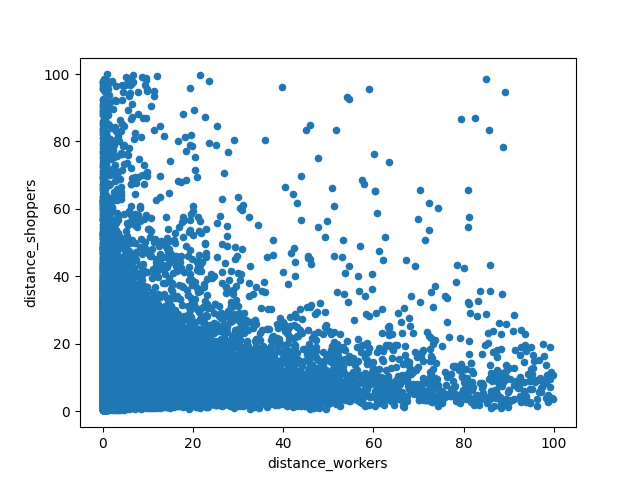

In [ ]:
# scatterplot
#foo = foo[(foo.distance_workers < 200) & (foo.distance_shoppers < 200)]
fig, ax = plt.subplots(nrows=1, ncols=1)
foo.plot.scatter(x = "distance_workers", y = "distance_shoppers", ax=ax)

# foo = foo.sort_values(by='distance_workers')
# coefs = np.polyfit(foo['distance_workers'], foo['distance_shoppers'], 2)
# p = np.poly1d(coefs)
# ax.plot(foo['distance_workers'], p(foo['distance_workers']), "r-")
%matplot plt
saveFigS3()

In [ ]:
# fixed effects reg
sc.install_pypi_package("FixedEffectModel")
from fixedeffect.iv import iv2sls, ivgmm, ivtest
from fixedeffect.fe import fixedeffect, did, getfe
from fixedeffect.utils.panel_dgp import gen_data


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


The directory '/home/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
You are using pip version 9.0.1, however version 23.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

In [ ]:
# # merge places back in
spend = spark.read.parquet(os.path.join(data_dyn, "spend_places"))
spend = spend.cache()
spend = spend.drop_duplicates(["placekey"])


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
dwells = dwells.join(spend, on = "placekey", how = "left")



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
dwells.select("safegraph_brand_ids").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
| safegraph_brand_ids|
+--------------------+
|SG_BRAND_a4efb9d8...|
|SG_BRAND_42aefbae...|
|SG_BRAND_04a8ca7b...|
|SG_BRAND_04a8ca7b...|
|SG_BRAND_04a8ca7b...|
|SG_BRAND_04a8ca7b...|
|SG_BRAND_6db086b9...|
|SG_BRAND_2e2448f1...|
|                null|
|SG_BRAND_a4efb9d8...|
|                null|
|SG_BRAND_b718bb44...|
|SG_BRAND_04a8ca7b...|
|SG_BRAND_cdba3261...|
|SG_BRAND_42aefbae...|
|SG_BRAND_04a8ca7b...|
|SG_BRAND_6db086b9...|
|SG_BRAND_6db086b9...|
|SG_BRAND_04a8ca7b...|
|SG_BRAND_2e2448f1...|
+--------------------+
only showing top 20 rows

In [ ]:
dfe = dwells.select("placekey", "postal_code", "distance_workers", "distance_shoppers", "safegraph_brand_ids").toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
dfe[['distance_workers', 'distance_shoppers']] = dfe[['distance_workers', 'distance_shoppers']] / 1000
dfe = dfe[(dfe.distance_workers < 100) & (dfe.distance_shoppers < 100)]


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
dfe[['distance_workers_log', 'distance_shoppers_log']] = np.log(dfe[['distance_workers', 'distance_shoppers']])


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
dfe['safegraph_brand_ids'] = pd.Categorical(dfe.safegraph_brand_ids)
dfe['brand_ids'] = dfe.safegraph_brand_ids.cat.codes

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
dfe['dist_workers_sq'] = dfe['distance_workers']**2

formula = 'distance_shoppers ~ distance_workers + dist_workers_sq  |postal_code + brand_ids |0|0'

model_fe = fixedeffect(data_df = dfe,
                       formula = formula,
                       no_print=True)
result = model_fe.fit()
result.summary()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                       High Dimensional Fixed Effect Regression Results                      
  Dep. Variable:      distance_shoppers   R-squared(proj model):                     0.0042  
  No. Observations:               67889   Adj. R-squared(proj model):               -0.2983  
  DoF of residual:              52072.0   R-squared(full model):                     0.6235  
  Residual std err:              5.9893   Adj. R-squared(full model):                0.5091  
  Covariance Type:            nonrobust   F-statistic(proj model):                  72.6712  
  Cluster Method:            no_cluster   Prob (F-statistic (proj model)):        3.043e-32  
                                          DoF of F-test (proj model):        [2.0, 52072.0]  
                                          F-statistic(full model):                   5.4513  
                                          Prob (F-statistic (full model)):                0  
                                          DoF of F-test (ful

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

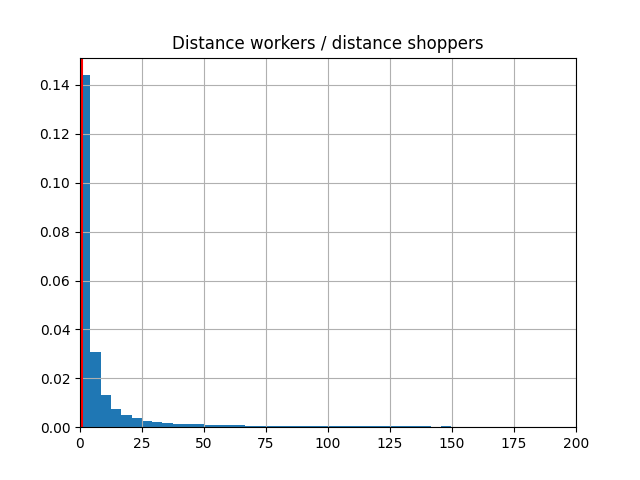

In [ ]:
plt.figure()
foo['ratio'] = foo['distance_workers'] / foo['distance_shoppers']
foo['ratio'].hist(bins = 1000, density=True)
plt.axvline(1, color = "red")
plt.xlim(0,10)
plt.title("Distance workers / distance shoppers")
%matplot plt


In [ ]:
foo[['distance_workers', 'distance_shoppers']].corr()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                   distance_workers  distance_shoppers
distance_workers           1.000000           0.143993
distance_shoppers          0.143993           1.000000

### Create price estimates

In [ ]:
spend = spark.read.parquet(os.path.join(data_dyn, "spend_places"))#.select("placekey",  "latitude", "longitude")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
allstores = spend.toPandas()
kroger = spend.filter(F.col("brands") == "Kroger").toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

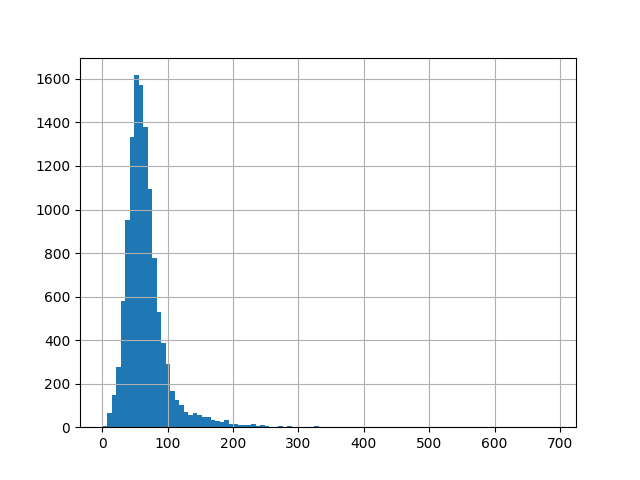

In [ ]:
plt.figure()
kroger['median_spend_per_customer'].hist(bins = 100)
%matplot plt


In [ ]:
plt.figure()
fig, ax = plt.subplots(nrows=1, ncols=1)
allstores['median_spend_per_customer'].hist(bins = 1000, ax=ax)
plt.xlim(0, 1000)
%matplot plt
saveFigS3(figs_dir + "price_dist.pdf", fig)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0.0, 1000.0)

In [ ]:
test = allstores.copy()
test['brands'] = test['brands'].astype('category')
test['brand_id'] = test.brands.cat.codes.astype(int)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
test['date_start'] = pd.to_datetime(test['spend_date_range_start']).dt.date

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
test = test[test.date_start == pd.to_datetime("2022-09-01")]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/usr/local/lib64/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)

In [ ]:
test

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                    placekey  ...  date_start
7        222-222@5pt-374-b6k  ...  2022-09-01
24       222-222@5qv-xj6-hqz  ...  2022-09-01
36       222-222@5qw-ssf-68v  ...  2022-09-01
48       222-222@5r8-56n-35z  ...  2022-09-01
60       222-222@5vg-thb-mkz  ...  2022-09-01
...                      ...  ...         ...
1235992  zzy-223@8gh-663-rtv  ...  2022-09-01
1236004  zzy-223@8sw-sqc-26k  ...  2022-09-01
1236016  zzy-224@5s9-9tt-789  ...  2022-09-01
1236028  zzy-229@5qv-x3q-mhq  ...  2022-09-01
1236040  zzy-22c@627-s6m-rrk  ...  2022-09-01

[106681 rows x 65 columns]

In [ ]:
formula = 'median_spend_per_customer ~ 0  | postal_code |0|0'

model_fe = fixedeffect(data_df = test,
                       formula = formula,
                       no_print=True)
result = model_fe.fit()
result.summary()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                           High Dimensional Fixed Effect Regression Results                          
  Dep. Variable:      median_spend_per_customer   R-squared(proj model):                          0  
  No. Observations:                      106681   Adj. R-squared(proj model):               -0.2301  
  DoF of residual:                      86726.0   R-squared(full model):                     0.1147  
  Residual std err:                     90.6572   Adj. R-squared(full model):               -0.0891  
  Covariance Type:                    nonrobust   F-statistic(proj model):                        0  
  Cluster Method:                    no_cluster   Prob (F-statistic (proj model)):              nan  
                                                  DoF of F-test (proj model):        [0.0, 86726.0]  
                                                  F-statistic(full model):                   0.5628  
                                                  Prob (F-statistic (full model)):

In [ ]:
test = test[test.longitude > -140]
test = test[test.latitude.between(23, 51)]
gdf = gpd.GeoDataFrame(test['median_spend_per_customer'], geometry = gpd.points_from_xy(test.longitude, test.latitude),
                      crs = "epsg:4326")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)
gdf.plot(column = "median_spend_per_customer", vmax = 200, markersize = 1, ax = ax)
saveFigS3(figs_dir + "map.pdf", fig)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
test['longitude'].describe()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

count    106681.000000
mean        -90.928207
std          14.898020
min        -166.547635
25%         -97.066328
50%         -86.602995
75%         -80.412108
max         -64.746376
Name: longitude, dtype: float64

In [ ]:
figs_dir

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

's3://ipsos-dvd/dyn/results/figs/'

### Grocery store descriptives

In [ ]:
spend = spark.read.parquet(os.path.join(data_dyn, "spend_places"))#.select("placekey",  "latitude", "longitude")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
spend.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['placekey', 'safegraph_brand_ids', 'brands', 'spend_date_range_start', 'spend_date_range_end', 'raw_total_spend', 'raw_num_transactions', 'raw_num_customers', 'median_spend_per_transaction', 'median_spend_per_customer', 'spend_per_transaction_percentiles', 'spend_by_day', 'spend_per_transaction_by_day', 'spend_by_day_of_week', 'day_counts', 'spend_pct_change_vs_prev_month', 'spend_pct_change_vs_prev_year', 'online_transactions', 'online_spend', 'transaction_intermediary', 'spend_by_transaction_intermediary', 'bucketed_customer_frequency', 'mean_spend_per_customer_by_frequency', 'bucketed_customer_incomes', 'mean_spend_per_customer_by_income', 'customer_home_city', 'related_cross_shopping_physical_brands_pct', 'related_cross_shopping_online_merchants_pct', 'related_cross_shopping_same_category_brands_pct', 'related_cross_shopping_local_brands_pct', 'related_wireless_carrier_pct', 'related_streaming_cable_pct', 'related_delivery_service_pct', 'related_rideshare_service_pct', 'related_bu

In [ ]:
brands = spend.select("brands").distinct().toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
brands.to_csv(data_dyn + "brands.csv")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
known_large_chains = [
    "Costco", "Kroger", "Walmart", "Target", "Safeway", "Publix",
    "Aldi", "Whole Foods", "Trader Joe's", "Wegmans", "Sam's Club",
    "Lidl", "H-E-B", "Albertsons", "Hy-Vee", "Meijer", "Giant Food",
    "Hannaford", "Stop & Shop", "WinCo Foods", "Sprouts Farmers Market",
    "ShopRite", "Food Lion", "Harris Teeter", "Ralphs", "Fred Meyer",
    "Vons", "Smith's", "Jewel-Osco", "Piggly Wiggly", "King Soopers",
    "Acme Markets", "BI-LO", "Dillons", "Fry's Food and Drug", "QFC",
    "Raley's", "Roundy's", "Save Mart Supermarkets", "Schnucks",
    "Shaw's and Star Market", "Stater Bros. Markets", "Winn-Dixie",
    "BJ's Wholesale Club"
]
sub_major_chains = [
    "Dollar General", "Family Dollar", "Dollar Tree", 
    "Marshalls", "Burlington",
    "Lowe's", "Home Depot",
    "Menards", "Tractor Supply Company"
]

# "Amazon Fresh", "H Mart", "Family Dollar Stores",
#    "Dollar General", "Dollar Tree",

grocery_chains = [
    "Costco", "Kroger", "Walmart", "Safeway", "Publix", "Aldi", "Whole Foods", 
    "Trader Joe's", "Wegmans", "Sam's Club", "Lidl", "H-E-B", "Albertsons", 
    "Hy-Vee", "Meijer", "Giant Food", "Hannaford", "Stop & Shop", 
    "WinCo Foods", "Sprouts Farmers Market", "ShopRite", "Food Lion", 
    "Harris Teeter", "Ralphs", "Fred Meyer", "Vons", "Smith's", 
    "Jewel-Osco", "Piggly Wiggly", "King Soopers", "Acme Markets", 
    "BI-LO", "Dillons", "Fry's Food and Drug", "QFC", "Raley's", 
    "Roundy's", "Save Mart Supermarkets", "Schnucks", "Shaw's and Star Market", 
    "Stater Bros. Markets", "Winn-Dixie", "Dollar General", "Family Dollar", 
    "Dollar Tree", "ALDI", "Grocery Outlet", "Price Chopper", "Fresh Thyme", 
    "The Fresh Market", "Market Basket", "Marc's", "Earth Fare", 
    "Lucky's Market", "Fareway", "Bashas'", "Brookshire's", "Harveys", 
    "Ingles", "Weis Markets", "Giant Eagle", "Cub Foods", "Heinen's"
]

expanded_grocery_chains = [
    "Costco", "Kroger", "Walmart Supercenter", "Safeway", "Publix", "Aldi", "Whole Foods Market", 
    "Trader Joe's", "Wegmans", "Sam's Club", "Lidl", "H-E-B", "Albertsons", 
    "Hy-Vee", "Meijer", "Giant Food", "Hannaford", "Stop & Shop", 
    "WinCo Foods", "Sprouts Farmers Market", "ShopRite", "Food Lion", 
    "Harris Teeter", "Ralphs", "Fred Meyer", "Vons", "Smith's", 
    "Jewel-Osco", "Piggly Wiggly", "King Soopers", "Acme Markets", 
    "Dillons", "Fry's Food and Drug", "Fry's", "QFC", "Raley's", 
    "Roundy's", "Save Mart Supermarkets", "Schnucks", "Shaw's and Star Market", 
    "Stater Bros. Markets", "Winn-Dixie", "Dollar General", "Family Dollar", 
    "Dollar Tree", "ALDI", "Grocery Outlet", "Price Chopper", "Fresh Thyme", 
    "The Fresh Market", "Market Basket", "Marc's", "Earth Fare", 
    "Lucky's Market", "Fareway", "Bashas'", "Brookshire's", "Harveys", 
    "Weis Markets", "Giant Eagle", "Cub Foods", "Heinen's",
    # Including Walmart and Target as they have significant grocery sections
    "Walmart", "Target", "Smart & Final", "Lin's Fresh Market", "Harmons", 
    "Marketplace Foods", "Lowes Foods", "Harps Food Store", "Tops Friendly Markets",
    "Foodtown", "Food City", "Ingles Markets"
]
# IGA: alliance of independent stores
# https://en.wikipedia.org/wiki/List_of_supermarket_chains_in_the_United_States
# bankrupt : BI-LO
# negligible: Harmons (20 stores), Lin's fresh market (7)